In [16]:
import os
from PIL import Image, ImageDraw
import numpy as np
import glob
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as F
import mlflow
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import torch.onnx
from sklearn.model_selection import train_test_split, KFold, ParameterGrid

import albumentations as A
from albumentations.pytorch import ToTensorV2

from dvclive import Live
import random
from PIL import Image, ImageEnhance
import numpy as np

import dvc.api
import json
import subprocess

import optuna

# Prepare data

In [17]:
def create_center_mask(image_size, max_percentage=10):
    """
    Create a mask with a black square in the center for the region to inpaint.

    Args:
        image_size (tuple): (width, height) of the image.
        max_percentage (float): Maximum percentage of the image area covered by the square.

    Returns:
        Image: Binary mask where 1 (or 255) represents the inpainting region.
    """
    width, height = image_size
    max_area = (width * height) * (max_percentage / 100)  # Maximum area of the square
    side_length = int(max_area**0.5)

    # Create an empty mask
    mask = Image.new("L", (width, height), 0)  # Binary mask (0 for background)
    draw = ImageDraw.Draw(mask)

    # Define the square's position
    x0 = (width - side_length) // 2
    y0 = (height - side_length) // 2
    x1 = x0 + side_length
    y1 = y0 + side_length

    # Draw the inpainting region as white (255)
    draw.rectangle([x0, y0, x1, y1], fill=255)

    return mask


In [18]:
normalize_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()  
])

augmentation_transforms_image = A.Compose([
    A.Rotate(limit=15, p=0.5),  # Random rotation (-15 to 15 degrees)
    A.HorizontalFlip(p=0.5),  # Horizontal flip (50% probability)
    A.VerticalFlip(p=0.5),  # Vertical flip (50% probability)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Random brightness/contrast adjustments
    # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),  # Hue, saturation, and value changes
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),  # Random contrast adjustment (Gamma)
    A.RandomCrop(width=224, height=224, p=1.0),  # Random crop to the same size as original images
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # Random blur (Gaussian blur)
    # ToTensorV2()  # Convert to tensor for PyTorch compatibility
], additional_targets={'maska': "image", "y": "image"})


In [34]:
class InpaintingDataset(Dataset):
    def __init__(self, X_paths, y_paths, mask, transform=None, augment_image=None):
        """
        Args:
            X_paths (list): List of paths to holed images (input).
            y_paths (list): List of paths to ground truth images (target).
            mask (PIL.Image): Precomputed binary mask for the inpainting region.
            transform (callable, optional): Optional transform to apply to the images.
        """
        self.X_paths = X_paths  # Holed images (input)
        self.y_paths = y_paths  # Ground truth images (target)
        self.mask = mask  # Convert mask to a tensor
        self.transform = transform
        self.augment_image = augment_image

    def __len__(self):
        return len(self.X_paths)

    def __getitem__(self, idx):
        # Load the holed (input) and ground truth (target) images
        X_path = self.X_paths[idx]
        y_path = self.y_paths[idx]

        X_image = Image.open(X_path).convert("RGB")
        y_image = Image.open(y_path).convert("RGB")
        mask = self.mask

        # Augment images here
        if self.augment_image:
            augmented = self.augment_image(image=np.array(X_image), maska = np.array(mask), y=np.array(y_image))
            X_image = augmented['image']
            y_image = augmented['y']
            mask = augmented['maska']

            X_image = Image.fromarray(X_image)  # Convert back to PIL Image
            y_image = Image.fromarray(y_image)  # Convert back to PIL Image
            mask = Image.fromarray(mask) 
            
        # Apply transforms (normalization or other general transforms)
        if self.transform:
            X_image = self.transform(X_image)
            y_image = self.transform(y_image)


        # Ensure the mask has the same spatial dimensions as the image
        mask_tensor = transforms.ToTensor()(mask)
        if mask_tensor.shape[-2:] != X_image.shape[-2:]:
            mask_tensor = torch.nn.functional.interpolate(
                mask_tensor.unsqueeze(0), size=X_image.shape[-2:]
            ).squeeze(0)

        # Create 4-channel input (holed image + mask)
        combined_input = torch.cat((X_image, mask_tensor), dim=0)

        return combined_input, y_image  # (Input: X_image + mask, Target: y_image)


image_size = (224, 224)  
mask = create_center_mask(image_size, max_percentage=10)

#PATHS
holed_dir = "./safe-data/Data/HoledImages/"
ground_truth_dir = "./safe-data/Data/VegetableImages/"

#Get dirs to files
holed_paths = sorted(glob.glob(os.path.join(holed_dir, "*.*"), recursive=True))
ground_truth_paths = sorted(glob.glob(os.path.join(ground_truth_dir, "*.*"), recursive=True))
assert len(holed_paths) == len(ground_truth_paths), "Mismatch between holed and ground truth images"

# SPLIT DATASET
X_train, X_test, y_train, y_test = train_test_split(
    holed_paths, ground_truth_paths, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Create the datasets for train, validation, and test
mask = create_center_mask((224, 224), max_percentage=10)

train_dataset = InpaintingDataset(
    X_paths=X_train,
    y_paths=y_train,
    mask=mask,
    transform=normalize_transform,
    augment_image=augmentation_transforms_image,
)

val_dataset = InpaintingDataset(
    X_paths=X_val,
    y_paths=y_val,
    mask=mask,
    transform=normalize_transform,
    augment_image=augmentation_transforms_image,
)

test_dataset = InpaintingDataset(
    X_paths=X_test,
    y_paths=y_test,
    mask=mask,
    transform=normalize_transform,
    augment_image=None,
)

# Create DataLoaders for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the data
for combined_input, target in test_loader:
    print(f"Input shape: {combined_input.shape}, Target shape: {target.shape}")
    break


Input shape: torch.Size([64, 4, 128, 128]), Target shape: torch.Size([64, 3, 128, 128])


In [35]:
# print(len(X_train))

1008


In [20]:
def create_center_mask(image_size, max_percentage=10):
    """
    Create a mask with a black square in the center for the region to inpaint.
    Args:
        image_size (tuple): (width, height) of the image.
        max_percentage (float): Maximum percentage of the image area covered by the square.
    Returns:
        Image: Binary mask where 1 (or 255) represents the inpainting region.
    """
    width, height = image_size
    max_area = (width * height) * (max_percentage / 100)  # Maximum area of the square
    side_length = int(max_area**0.5)

    # Create an empty mask
    mask = Image.new("L", (width, height), 0)  # Binary mask (0 for background)
    draw = ImageDraw.Draw(mask)

    # Define the square's position
    x0 = (width - side_length) // 2
    y0 = (height - side_length) // 2
    x1 = x0 + side_length
    y1 = y0 + side_length

    # Draw the inpainting region as white (255)
    draw.rectangle([x0, y0, x1, y1], fill=255)

    return mask

# Model

In [21]:
class FastInpaintingModelWithSkip(nn.Module):
    def __init__(self):
        super(FastInpaintingModelWithSkip, self).__init__()
        
        # Encoder layers
        self.enc1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=4, stride=2, padding=1),  # Fewer filters for faster computation
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Fewer parameters in bottleneck
            nn.ReLU()
        )
        
        # Decoder layers with skip connections
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # Skip connection from enc3
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=4, stride=2, padding=1),  # Skip connection from enc2
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(32 + 32, 3, kernel_size=4, stride=2, padding=1),  # Skip connection from enc1
            nn.Sigmoid()  # Pixel values in [0, 1]
        )
    
    def forward(self, x):
        # Encoding path
        enc1 = self.enc1(x)  # Output: (B, 32, 112, 112)
        enc2 = self.enc2(enc1)  # Output: (B, 64, 56, 56)
        enc3 = self.enc3(enc2)  # Output: (B, 128, 28, 28)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc3)  # Output: (B, 256, 14, 14)
        
        # Decoding path with skip connections
        dec1 = self.dec1(bottleneck)  # Output: (B, 128, 28, 28)
        dec2 = self.dec2(torch.cat([dec1, enc3], dim=1))  # Skip connection from enc3
        dec3 = self.dec3(torch.cat([dec2, enc2], dim=1))  # Skip connection from enc2
        dec4 = self.dec4(torch.cat([dec3, enc1], dim=1))  # Skip connection from enc1
        
        return dec4

# Instantiate the model
model = FastInpaintingModelWithSkip()
print(model)


FastInpaintingModelWithSkip(
  (enc1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (dec1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dec2): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding

In [22]:
loss_fn = nn.MSELoss()  # Pixel-wise MSE loss

In [23]:
def masked_loss(output, target, mask):
    """
    Compute MSE loss only for the masked region.

    Args:
        output (Tensor): Model output (B, C, H, W).
        target (Tensor): Ground truth image (B, C, H, W).
        mask (Tensor): Binary mask indicating the region to inpaint (B, 1, H, W).

    Returns:
        Tensor: Loss value.
    """
    mask = mask.to(output.device)  # Ensure mask is on the same device
    loss = ((output - target) ** 2) * mask  # Apply the mask
    return loss.sum() / mask.sum()  # Normalize by the number of pixels in the mask


In [24]:
# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FastInpaintingModelWithSkip().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()  # Pixel-wise MSE loss


# Training

In [ ]:
num_epochs = 50

model_path = "model_8.pth"
try:
    subprocess.run(["git", "ls-files", "--error-unmatch", model_path], check=True)
    subprocess.run(["git", "rm", "--cached", model_path], check=True)
    subprocess.run(["git", "commit", "-m", f"Stop tracking {model_path} with Git"], check=True)
    print(f"Stopped tracking {model_path} in Git.")
except subprocess.CalledProcessError:
    print(f"{model_path} is not tracked by Git.")
    
start_time = time.time()

# Enable DVC experiment tracking
with Live(save_dvc_exp=True) as live:
    live.log_param("Learning Rate", 1e-3)
    live.log_param("Batch Size", 64)
    live.log_param("Dataset Size", len(train_dataset))
    live.log_param("Loss Function", "Masked MSE Loss")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for combined_input, target in train_loader:
            combined_input, target = combined_input.to(device), target.to(device)

            mask = combined_input[:, 3:4, :, :]

            # Forward pass
            output = model(combined_input)
            loss = masked_loss(output, target, mask)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        live.log_metric("train/loss", avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")


        live.next_step()  # Mark the next training step
    
    total_time = time.time() - start_time  # Compute training duration
    live.log_metric("train/time", total_time)  # Log training time

    # Save the model to a path
    model_path = "model_8.pth"
    torch.save(model.state_dict(), model_path)

    # Log model file in DVC and save it properly
    live.log_artifact(model_path, type="model")

    subprocess.run(["dvc", "add", model_path], check=True)
    subprocess.run(["git", "add", f"{model_path}.dvc"], check=True)
    subprocess.run(["git", "commit", "-m", "Add model to DVC"], check=True)
    print(f"Model saved and tracked by DVC: {model_path}")


# Cross validation

In [ ]:
num_epochs = 20
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Dataset paths
holed_paths = sorted(glob.glob(os.path.join(holed_dir, "*.*"), recursive=True))
ground_truth_paths = sorted(glob.glob(os.path.join(ground_truth_dir, "*.*"), recursive=True))
assert len(holed_paths) == len(ground_truth_paths), "Mismatch between holed and ground truth images"

mask = create_center_mask((224,224), max_percentage=10)

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Training fold {fold+1}/{k_folds}")

    X_train_fold = [X_train[i] for i in train_idx]
    y_train_fold = [y_train[i] for i in train_idx]
    X_val_fold = [X_train[i] for i in val_idx]
    y_val_fold = [y_train[i] for i in val_idx]

    train_dataset = InpaintingDataset(
        X_paths=X_train_fold,
        y_paths=y_train_fold,
        mask=create_center_mask((224, 224), max_percentage=10),
        transform=normalize_transform,
        augment_image=augmentation_transforms_image,
    )

    val_dataset = InpaintingDataset(
        X_paths=X_val_fold,
        y_paths=y_val_fold,
        mask=create_center_mask((224, 224), max_percentage=10),
        transform=normalize_transform,
        augment_image=augmentation_transforms_image,
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model_path = f"model_{fold+1}.pth"
    try:
        subprocess.run(["git", "ls-files", "--error-unmatch", model_path], check=True)
        subprocess.run(["git", "rm", "--cached", model_path], check=True)
        subprocess.run(["git", "commit", "-m", f"Stop tracking {model_path} with Git"], check=True)
        print(f"Stopped tracking {model_path} in Git.")
    except subprocess.CalledProcessError:
        print(f"{model_path} is not tracked by Git.")


    # Enable DVC experiment tracking
    with Live(save_dvc_exp=True) as live:
        live.log_param("Learning Rate", 1e-3)
        live.log_param("Batch Size", 64)
        live.log_param("Dataset Size", len(train_subset))  # Size of the current fold's training data
        live.log_param("Loss Function", "Masked MSE Loss")
        live.log_param("Fold", fold +1)

        # Train the model for the current fold
        start_time = time.time()

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0.0

            for combined_input, target in train_loader:
                combined_input, target = combined_input.to(device), target.to(device)

                # Get the mask for the input
                mask = combined_input[:, 3:4, :, :]

                # Forward pass
                output = model(combined_input)
                loss = masked_loss(output, target, mask)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            live.log_metric("train/loss", avg_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")

            live.next_step()  # Mark the next training step

        # Log the time taken for the fold
        total_time = time.time() - start_time
        live.log_metric("train/time", total_time)

        # Save the model for the current fold
        model_path = f"model_{fold+1}.pth"
        torch.save(model.state_dict(), model_path)
        live.log_artifact(model_path, type="model")


        subprocess.run(["dvc", "add", model_path], check=True)
        subprocess.run(["git", "add", f"{model_path}.dvc"], check=True)
        subprocess.run(["git", "commit", "-m", f"Add model {fold+1} to DVC"], check=True)
        print(f"Model saved and tracked by DVC: {model_path}")

        # evaluate on validation set after each fold
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for combined_input, target in val_loader:
                combined_input, target = combined_input.to(device), target.to(device)
                output = model(combined_input)
                mask = combined_input[:, 3:4, :, :]
                val_loss += masked_loss(output, target, mask).item()

        avg_val_loss = val_loss / len(val_loader)
        live.log_metric("val/loss", avg_val_loss)
        print(f"Fold {fold+1} Validation Loss: {avg_val_loss:.4f}")
    subprocess.run(["git", "add", "."], check=True)
    subprocess.run(["git", "commit", "-m", "Add all model metrics"], check=True)
    print(f"Metrics saved to git")
    
print("Cross-validation complete.")


Training fold 1/5
model_1.pth is not tracked by Git.
Epoch [1/1], Train Loss: 0.0969


Model saved and tracked by DVC: model_1.pth
Fold 1 Validation Loss: 0.0907
Training fold 2/5
model_2.pth is not tracked by Git.
Epoch [1/1], Train Loss: 0.0902


Model saved and tracked by DVC: model_2.pth
Fold 2 Validation Loss: 0.0872
Training fold 3/5
model_3.pth is not tracked by Git.
Epoch [1/1], Train Loss: 0.0884


Model saved and tracked by DVC: model_3.pth
Fold 3 Validation Loss: 0.0934
Training fold 4/5
model_4.pth is not tracked by Git.
Epoch [1/1], Train Loss: 0.0839


Model saved and tracked by DVC: model_4.pth
Fold 4 Validation Loss: 0.0796
Training fold 5/5
model_5.pth is not tracked by Git.
Epoch [1/1], Train Loss: 0.0838


Model saved and tracked by DVC: model_5.pth
Fold 5 Validation Loss: 0.0819
Cross-validation complete.


In [27]:
def visualize_inpainting(test_loader, model):
    model.eval()
    with torch.no_grad():
        for combined_input, target in test_loader:
            combined_input, target = combined_input.to(device), target.to(device)
            output = model(combined_input)

            # Extract mask, input image, and ground truth
            input_image = combined_input[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            mask = combined_input[:, 3:4, :, :].cpu().numpy()  # (B, 1, H, W)
            target_image = target.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            output_image = output.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)

            # Rescale images from [0, 1] to [0, 255] for visualization
            input_image = (input_image * 255).astype(np.uint8)
            target_image = (target_image * 255).astype(np.uint8)
            output_image = (output_image * 255).astype(np.uint8)

            # Combine inpainted region with the input image for visualization
            inpainted_image = input_image[0].copy()
            mask_numpy = mask[0, 0]  # Convert mask to 2D numpy array
            inpainted_image[mask_numpy > 0] = output_image[0][mask_numpy > 0]

            # Visualize
            import matplotlib.pyplot as plt
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Input (Holed)")
            plt.imshow(input_image[0])  # RGB image
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(target_image[0])  # RGB image
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Inpainted Output")
            plt.imshow(inpainted_image)  # RGB image
            plt.axis("off")

            plt.show()
            # break


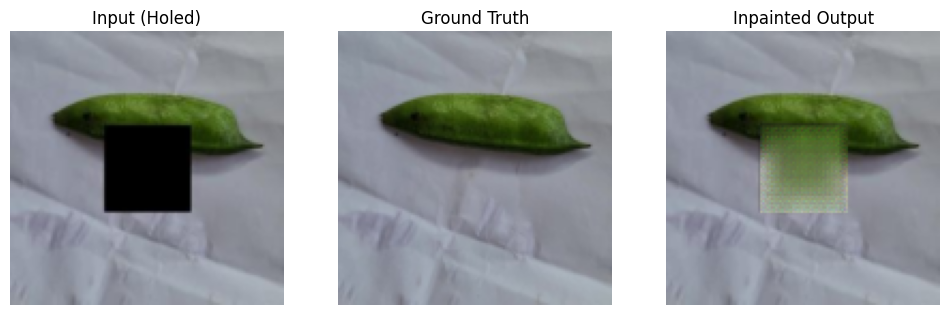

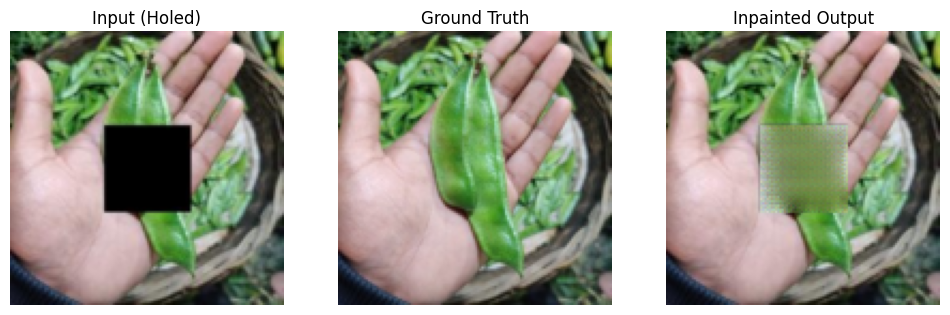

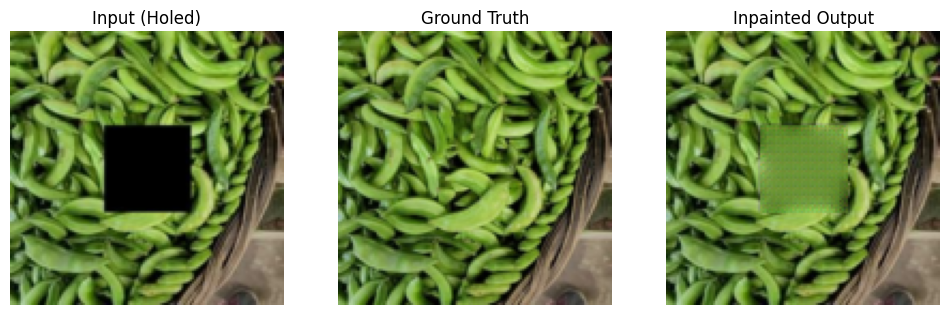

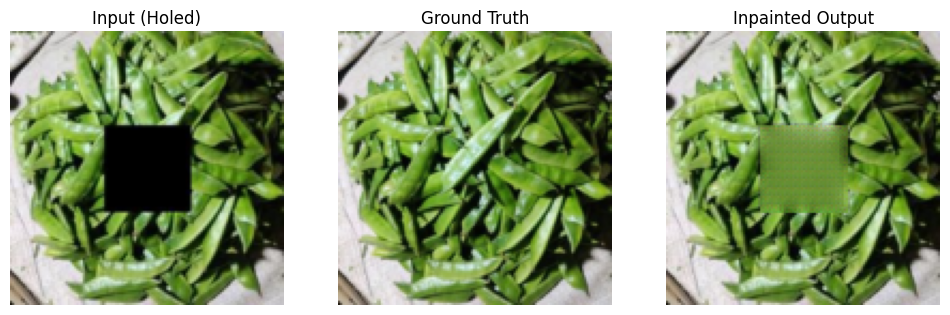

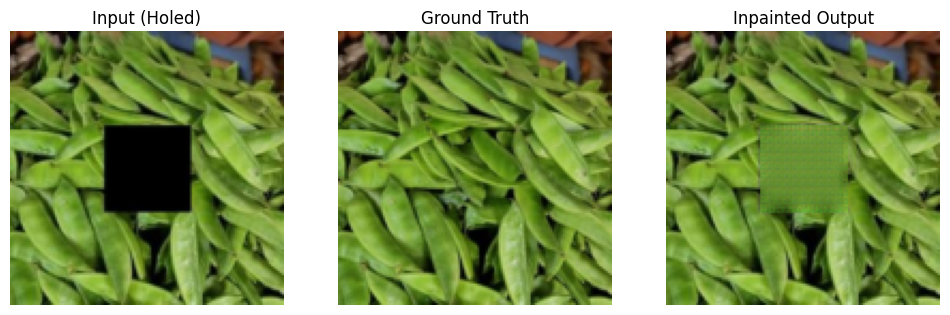

In [40]:
# Visualize the results
visualize_inpainting(test_loader, model)

In [29]:
def evaluate_model(test_loader, model, loss_fn, log_to_mlflow=True):
    """
    Evaluate the model on the test dataset.

    Args:
        test_loader (DataLoader): DataLoader for the test dataset.
        model (nn.Module): Trained inpainting model.
        loss_fn (callable): Loss function for evaluation.
        log_to_mlflow (bool): Whether to log the evaluation metrics to MLflow.

    Returns:
        dict: Evaluation results containing test loss and optional metrics.
    """
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0  # For computing PSNR

    num_batches = len(test_loader)
    total_images = num_batches * test_loader.batch_size

    with torch.no_grad():
        for combined_input, target in test_loader:
            combined_input, target = combined_input.to(device), target.to(device)
            mask = combined_input[:, 3:4, :, :]  # Extract the mask channel
            output = model(combined_input)

            # Compute loss
            loss = masked_loss(output, target, mask)
            total_loss += loss.item()

            # Compute additional metrics (e.g., PSNR)
            output_np = (output.cpu().numpy() * 255).astype(np.uint8)
            target_np = (target.cpu().numpy() * 255).astype(np.uint8)
            for b in range(output_np.shape[0]):  # Loop over the batch
                psnr = compute_psnr(output_np[b], target_np[b])
                total_psnr += psnr

    avg_loss = total_loss / num_batches
    avg_psnr = total_psnr / total_images

    # Log results to MLflow
    if log_to_mlflow:
        mlflow.log_metric("Test Loss", avg_loss)
        mlflow.log_metric("Test PSNR", avg_psnr)
        mlflow.log_param("Total Test Images", total_images)  # Log number of images

    # Print results
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test PSNR: {avg_psnr:.4f}")
    print(f"Total Test Images: {total_images}")

    return {
        "test_loss": avg_loss,
        "test_psnr": avg_psnr,
        "total_test_images": total_images,
    }


# Helper function to compute PSNR
def compute_psnr(output, target):
    mse = np.mean((output - target) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if there's no error
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


In [30]:
evaluation_results = evaluate_model(test_loader, model, loss_fn)

Test Loss: 0.1149
Test PSNR: 24.5565
Total Test Images: 320


# Evaluation on images acquired

In [31]:
holes_500_dir = "./safe-data/500images/VegetableImages/"  #CHANGE HERE TO GET YOUR PATH
truth_500_dir = "./safe-data/500images/HoledImages/"

holes_500 = sorted(glob.glob(os.path.join(holes_500_dir, "*.*"), recursive=True))
truth_500 = sorted(glob.glob(os.path.join(truth_500_dir, "*.*"), recursive=True))

dataset_500 = InpaintingDataset(
    X_paths=holes_500,
    y_paths=truth_500,
    mask=mask,
    transform=normalize_transform,
    augment_image=None,
)

test_500_loader = DataLoader(dataset_500, batch_size=64, shuffle=False)

evaluation_results = evaluate_model(test_500_loader, model, loss_fn)

ZeroDivisionError: float division by zero